Training Accuracy: 0.80
Testing Accuracy: 0.72
real Testing Accuracy: 0.35


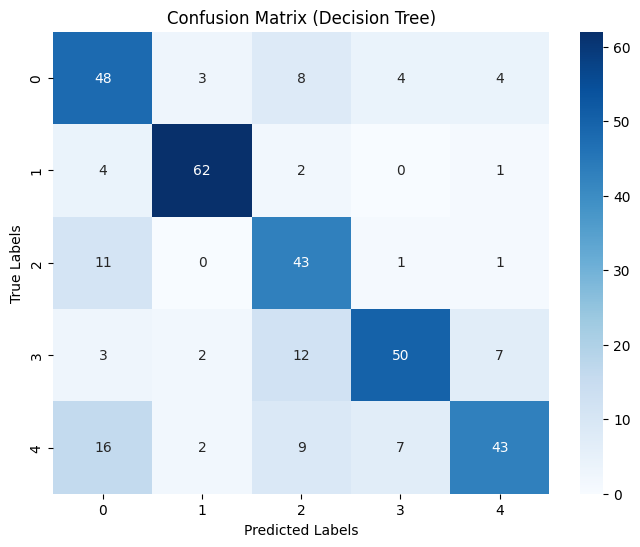

False Negative Rate (FNR) for each class:
Class 0: 0.28
Class 1: 0.10
Class 2: 0.23
Class 3: 0.32
Class 4: 0.44

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.72      0.64        67
           1       0.90      0.90      0.90        69
           2       0.58      0.77      0.66        56
           3       0.81      0.68      0.74        74
           4       0.77      0.56      0.65        77

    accuracy                           0.72       343
   macro avg       0.73      0.72      0.72       343
weighted avg       0.74      0.72      0.72       343



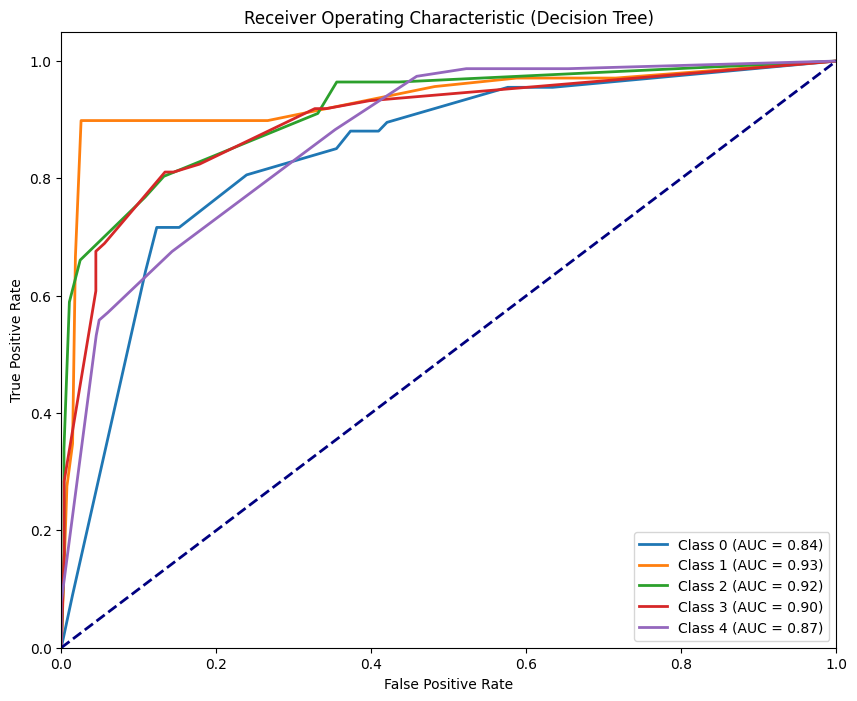

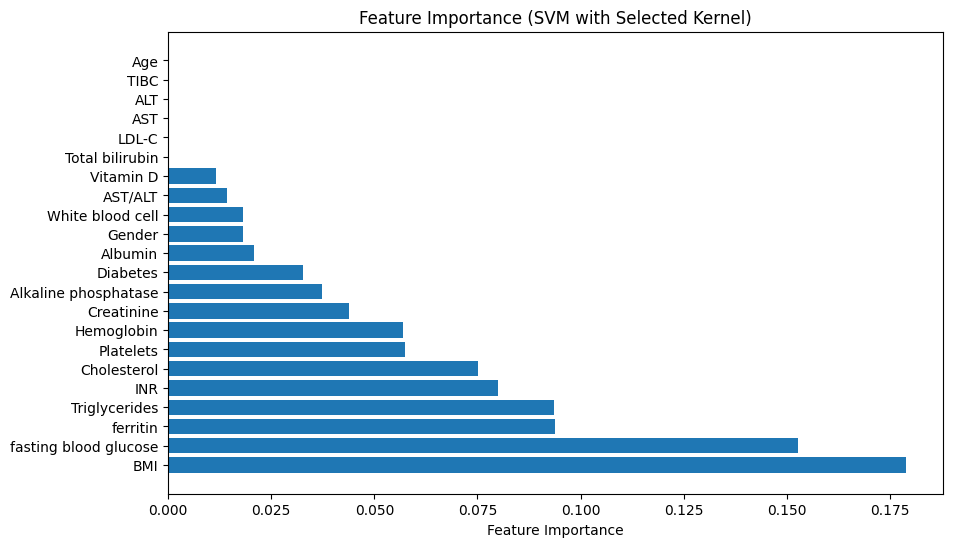

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Load training dataset
data = pd.read_excel('/content/augmented_train_data_noise_1.xlsx')
data.fillna(data.mean(numeric_only=True), inplace=True)


# Load external test dataset
test_data_from_file = pd.read_excel('/content/test_data_1.xlsx')
test_data_from_file.fillna(test_data_from_file.mean(numeric_only=True), inplace=True)


# Splitting features and target
X = data.drop('steato score', axis=1)
y = data['steato score']

# Split the data into training and internal testing sets
X_train, X_test_temp, y_train, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine internal test and external test data
X_test_combined = pd.concat([X_test_temp, test_data_from_file.drop('steato score', axis=1)], axis=0)
y_test_combined = pd.concat([y_test_temp, test_data_from_file['steato score']], axis=0)


# Initialize and train Decision Tree model
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'ccp_alpha': [0.01, 0.1]
}


grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best Model selected
model_dt = grid_search.best_estimator_

train_acc = model_dt.score(X_train, y_train)
test_acc = model_dt.score(X_test_combined, y_test_combined)
real_test_acc = model_dt.score(test_data_from_file.drop('steato score', axis=1),test_data_from_file['steato score'])

print(f"Training Accuracy: {train_acc:.2f}")
print(f"Testing Accuracy: {test_acc:.2f}")
print(f"real Testing Accuracy: {real_test_acc:.2f}")


# Evaluate the model on combined test data
y_test_pred_combined_dt = model_dt.predict(X_test_combined)
y_test_prob_combined_dt = model_dt.predict_proba(X_test_combined)

# Confusion Matrix
cm_combined_dt = confusion_matrix(y_test_combined, y_test_pred_combined_dt)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined_dt, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test_combined), yticklabels=np.unique(y_test_combined))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Decision Tree)')
plt.show()


# Calculate and display False Negative Rate (FNR) for each class
print("False Negative Rate (FNR) for each class:")
classes = np.unique(y_test_combined)  # Unique classes
for i, cls in enumerate(classes):
    fn = cm_combined_dt[i, :].sum() - cm_combined_dt[i, i]  # False Negatives
    tp = cm_combined_dt[i, i]  # True Positives
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    print(f"Class {cls}: {fnr:.2f}")


# Classification Report
classes = np.unique(y_test_combined)  # Unique classes
report_dt = classification_report(y_test_combined, y_test_pred_combined_dt, target_names=classes.astype(str))
print("\nClassification Report:\n", report_dt)


# ROC Curve
plt.figure(figsize=(10, 8))
for i, cls in enumerate(model_dt.classes_):
    fpr, tpr, _ = roc_curve((y_test_combined == cls).astype(int), y_test_prob_combined_dt[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {cls} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Decision Tree)')
plt.legend(loc="lower right")
plt.show()

# Feature Importance
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(model_dt, X_test_combined, y_test_combined, n_repeats=10, random_state=42)
importance_scores = perm_importance.importances_mean
# Sort feature importances
sorted_idx_perm = np.argsort(importance_scores)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx_perm], importance_scores[sorted_idx_perm])
plt.xlabel('Feature Importance')
plt.title('Feature Importance ')
plt.show()


Top Features for Class 0 based on predict_proba:
BMI: 0.0093
AST/ALT: 0.0023
Age: 0.0000
Total bilirubin: 0.0000
White blood cell: 0.0000
Gender: 0.0000
Diabetes: 0.0000
TIBC: 0.0000
LDL-C: 0.0000
ALT: 0.0000
AST: 0.0000
Albumin: 0.0000
Alkaline phosphatase: -0.0015
Cholesterol: -0.0017
Vitamin D: -0.0026
Triglycerides: -0.0041
Platelets: -0.0114
fasting blood glucose: -0.0114
INR: -0.0134
ferritin: -0.0236
Creatinine: -0.0303
Hemoglobin: -0.0379


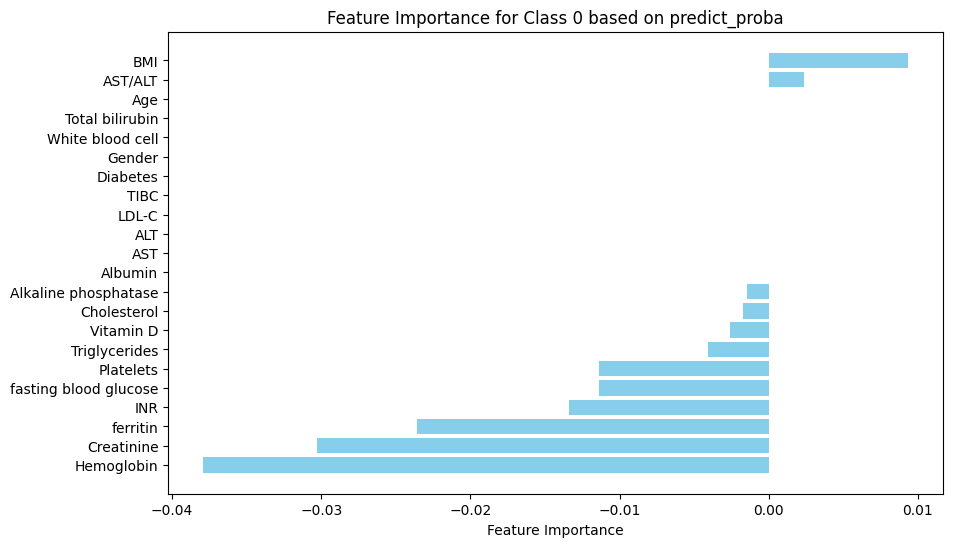


Top Features for Class 1 based on predict_proba:
fasting blood glucose: 0.0636
INR: 0.0560
Hemoglobin: 0.0554
BMI: 0.0519
Triglycerides: 0.0414
Diabetes: 0.0338
Cholesterol: 0.0224
Platelets: 0.0140
AST/ALT: 0.0120
Creatinine: 0.0111
Alkaline phosphatase: 0.0082
Vitamin D: 0.0073
ferritin: 0.0050
Albumin: 0.0000
Total bilirubin: 0.0000
AST: 0.0000
ALT: 0.0000
LDL-C: 0.0000
TIBC: 0.0000
Gender: 0.0000
White blood cell: 0.0000
Age: 0.0000


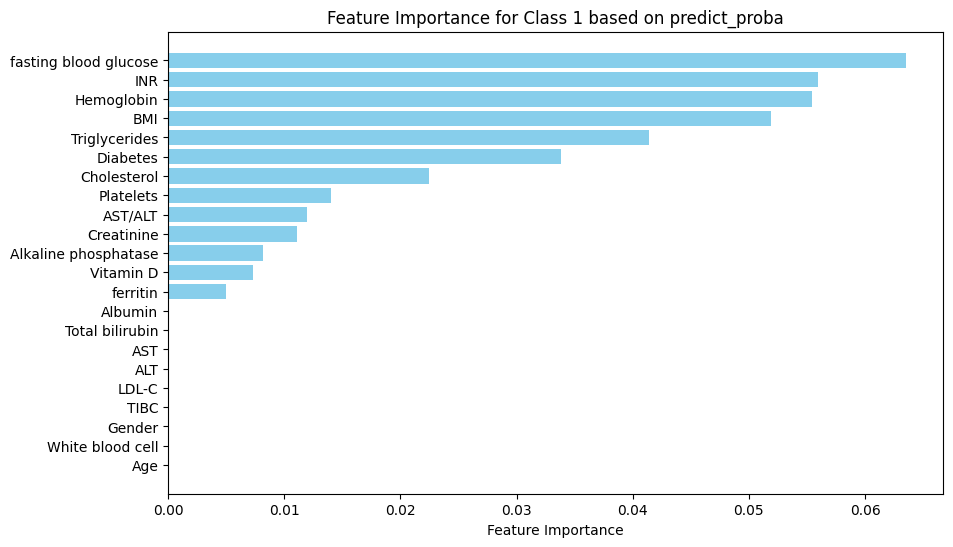


Top Features for Class 2 based on predict_proba:
Triglycerides: 0.0233
fasting blood glucose: 0.0227
BMI: 0.0201
Platelets: 0.0099
Vitamin D: 0.0090
INR: 0.0003
Age: 0.0000
ALT: 0.0000
White blood cell: 0.0000
Diabetes: 0.0000
TIBC: 0.0000
LDL-C: 0.0000
Gender: 0.0000
Albumin: 0.0000
Total bilirubin: 0.0000
AST: 0.0000
Creatinine: -0.0009
Alkaline phosphatase: -0.0012
Cholesterol: -0.0015
AST/ALT: -0.0023
Hemoglobin: -0.0210
ferritin: -0.0219


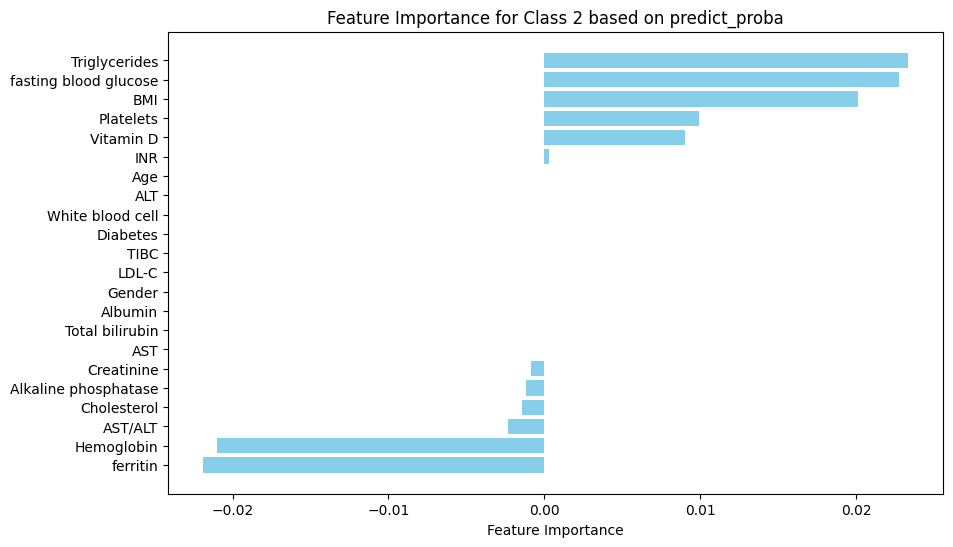


Top Features for Class 3 based on predict_proba:
Triglycerides: 0.0516
fasting blood glucose: 0.0434
BMI: 0.0283
Platelets: 0.0111
ferritin: 0.0102
Vitamin D: 0.0082
Creatinine: 0.0047
INR: 0.0035
Diabetes: 0.0015
Gender: 0.0000
ALT: 0.0000
AST: 0.0000
Age: 0.0000
Total bilirubin: 0.0000
Albumin: 0.0000
LDL-C: 0.0000
TIBC: 0.0000
White blood cell: 0.0000
Alkaline phosphatase: -0.0020
AST/ALT: -0.0041
Cholesterol: -0.0175
Hemoglobin: -0.0198


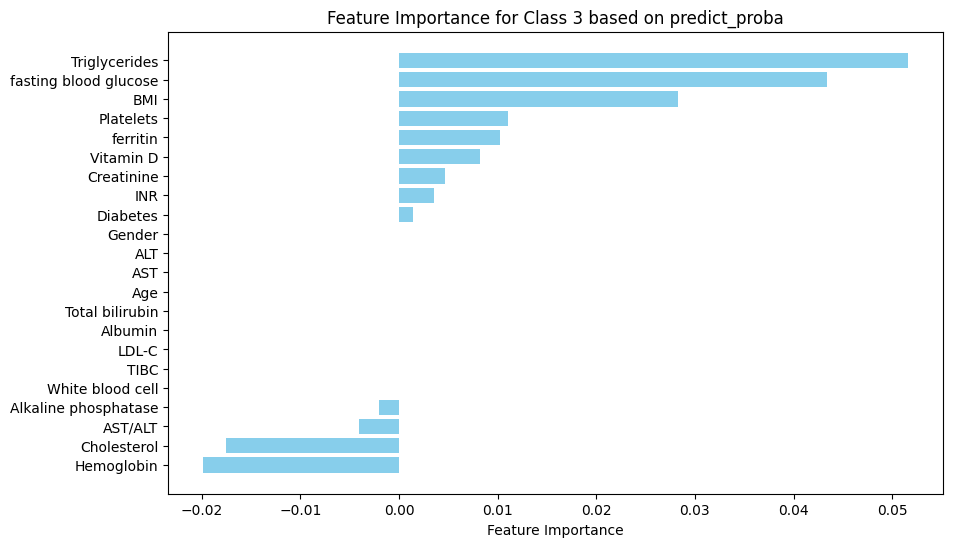


Top Features for Class 4 based on predict_proba:
fasting blood glucose: 0.0338
BMI: 0.0292
Triglycerides: 0.0207
Vitamin D: 0.0073
Diabetes: 0.0012
Age: 0.0000
AST: 0.0000
White blood cell: 0.0000
Gender: 0.0000
TIBC: 0.0000
LDL-C: 0.0000
Albumin: 0.0000
Total bilirubin: 0.0000
ALT: 0.0000
Cholesterol: -0.0012
Alkaline phosphatase: -0.0012
INR: -0.0023
AST/ALT: -0.0035
Platelets: -0.0050
ferritin: -0.0085
Creatinine: -0.0111
Hemoglobin: -0.0190


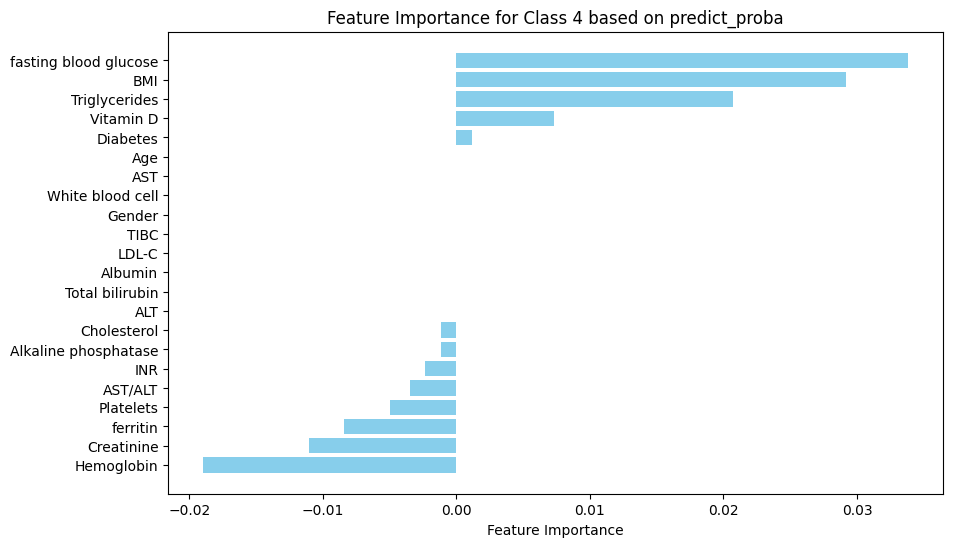

In [ ]:
from sklearn.inspection import permutation_importance

# Feature Importance for each class separately using predict_proba
feature_importances_per_class_proba_dt = {}

# Loop over each class in the model
for class_index, cls in enumerate(model_dt.classes_):
    # Binary target for the current class
    y_binary = (y_test_combined == cls).astype(int)

    # Get predicted probabilities for the current class
    y_pred_proba = model_dt.predict_proba(X_test_combined)[:, class_index]

    # Calculate feature importance based on predict_proba
    result = permutation_importance(model_dt, X_test_combined, y_binary,
                                    scoring='accuracy', n_repeats=10, random_state=42)

    importance_scores = result.importances_mean
    sorted_idx = np.argsort(importance_scores)[::-1]
    sorted_features = np.array(X.columns)[sorted_idx]
    sorted_scores = importance_scores[sorted_idx]

    # Store the results for later use
    feature_importances_per_class_proba_dt[cls] = {
        'features': sorted_features,
        'scores': sorted_scores
    }

    # Print important features for the class
    print(f"\nTop Features for Class {cls} based on predict_proba:")
    for feature, score in zip(sorted_features, sorted_scores):
        print(f"{feature}: {score:.4f}")

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_scores, color='skyblue')
    plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance for Class {cls} based on predict_proba')
    plt.show()
